# Sentiment Analysis and Trading

### Import

In [1]:
%load_ext autoreload
%autoreload 2
from finBert_trading import *

## 0050

In [2]:
MEDIA = 'UDN'
KEYWORD = 'ETF'
STOCK = '0050.TW'
DAY_RANGE = '1d'
content_type = 'Title'

100%|██████████| 6623/6623 [00:05<00:00, 1204.58it/s]


Map:   0%|          | 0/290 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

Average daily return | sentiment: 0.0025931503884258794 | buyhold: 0.0025081626755337314
Std daily return     | sentiment: 0.008078207794193697  | buyhold: 0.01313545382623187


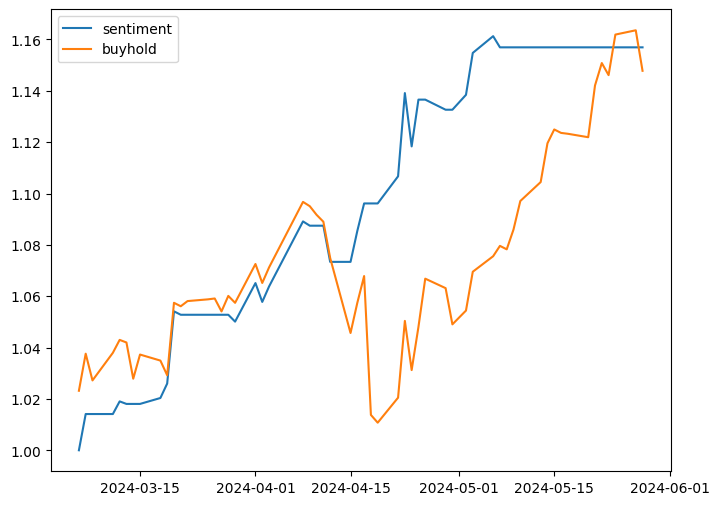

In [3]:
"""
NOTE:
- The first file is the target stock
- Train with target stock data and other stock data
"""
filename_news = [
    'data/TW-stock-news-price/date/NEWS_UDN_ETF_EN.json'
    ]
filename_price = [
    'data/TW-stock-news-price/date/PRICE_0050.TW_1d.pickle'
    ]
filename_log = f'logs/finBert_day_ERROR_{MEDIA}_{KEYWORD}'
senti = finBert_Sentiment(MEDIA, KEYWORD, STOCK, DAY_RANGE, content_type, filename_news, filename_price, filename_log)
senti.set_seeds()

all, train, val, test = senti.load_data(text_type = 'title')
senti.evaluate_with_pretrained()

{'eval_loss': 4.513059139251709, 'eval_accuracy': 0.36, 'eval_runtime': 0.2431, 'eval_samples_per_second': 102.827, 'eval_steps_per_second': 4.113, 'epoch': 5.71}
{'eval_loss': 4.304644584655762, 'eval_accuracy': 0.36, 'eval_runtime': 0.2468, 'eval_samples_per_second': 101.286, 'eval_steps_per_second': 4.051, 'epoch': 11.43}
{'eval_loss': 3.974097490310669, 'eval_accuracy': 0.36, 'eval_runtime': 0.2479, 'eval_samples_per_second': 100.835, 'eval_steps_per_second': 4.033, 'epoch': 17.14}
{'eval_loss': 3.5377414226531982, 'eval_accuracy': 0.28, 'eval_runtime': 0.2484, 'eval_samples_per_second': 100.659, 'eval_steps_per_second': 4.026, 'epoch': 22.86}
{'eval_loss': 3.066269636154175, 'eval_accuracy': 0.28, 'eval_runtime': 0.247, 'eval_samples_per_second': 101.214, 'eval_steps_per_second': 4.049, 'epoch': 28.57}
{'eval_loss': 2.711576223373413, 'eval_accuracy': 0.24, 'eval_runtime': 0.2487, 'eval_samples_per_second': 100.524, 'eval_steps_per_second': 4.021, 'epoch': 34.29}
{'eval_loss': 2.4

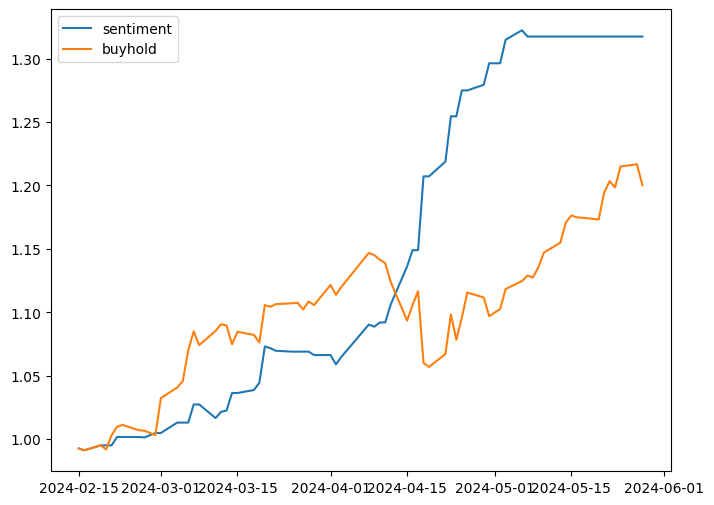

In [4]:
result = senti.finetuneFull_score_trade(True)
# result = senti.finetuneLora_score_trade(True)

## 2409

### Finetuned with only related keyword data
- First picture: Backtest with pretrained model 
- Second picture: Backtest and finetuned the model 

In [5]:
MEDIA = 'UDN'
KEYWORD = '友達'
STOCK = '2409.TW'
DAY_RANGE = '1d'
content_type = 'Title'

100%|██████████| 1301/1301 [00:01<00:00, 1036.56it/s]


Map:   0%|          | 0/263 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Average daily return | sentiment: 0.0004383573977240331 | buyhold: 0.0005197868456346585
Std daily return     | sentiment: 0.012820232785803926  | buyhold: 0.01806351768320411


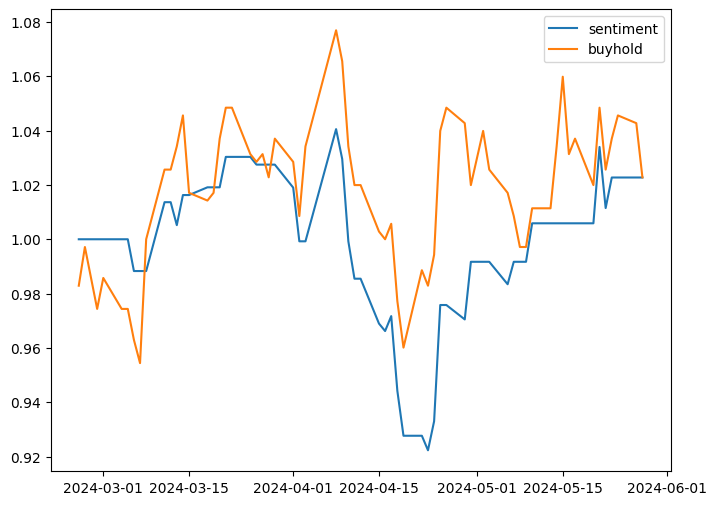

{'eval_loss': 5.992427825927734, 'eval_accuracy': 0.28, 'eval_runtime': 0.2459, 'eval_samples_per_second': 101.664, 'eval_steps_per_second': 4.067, 'epoch': 6.67}


{'eval_loss': 5.788784027099609, 'eval_accuracy': 0.28, 'eval_runtime': 0.2455, 'eval_samples_per_second': 101.834, 'eval_steps_per_second': 4.073, 'epoch': 13.33}
{'eval_loss': 5.455097198486328, 'eval_accuracy': 0.28, 'eval_runtime': 0.2468, 'eval_samples_per_second': 101.277, 'eval_steps_per_second': 4.051, 'epoch': 20.0}
{'eval_loss': 5.006048202514648, 'eval_accuracy': 0.28, 'eval_runtime': 0.2476, 'eval_samples_per_second': 100.965, 'eval_steps_per_second': 4.039, 'epoch': 26.67}
{'eval_loss': 4.438081741333008, 'eval_accuracy': 0.32, 'eval_runtime': 0.2463, 'eval_samples_per_second': 101.493, 'eval_steps_per_second': 4.06, 'epoch': 33.33}
{'eval_loss': 3.8955202102661133, 'eval_accuracy': 0.36, 'eval_runtime': 0.2496, 'eval_samples_per_second': 100.155, 'eval_steps_per_second': 4.006, 'epoch': 40.0}
{'eval_loss': 3.5005218982696533, 'eval_accuracy': 0.4, 'eval_runtime': 0.2487, 'eval_samples_per_second': 100.536, 'eval_steps_per_second': 4.021, 'epoch': 46.67}
{'eval_loss': 3.23

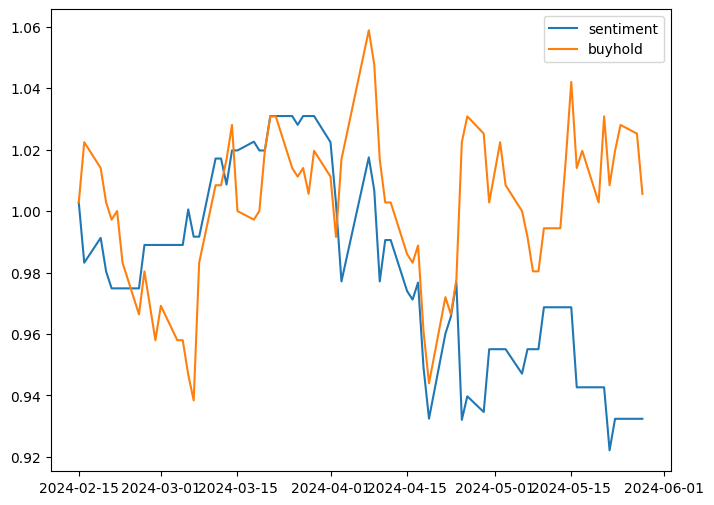

In [6]:
"""
NOTE:
- The first file is the target stock
- Train with target stock data and other stock data
"""
filename_news = [
    f'data/TW-stock-news-price/date/NEWS_{MEDIA}_{KEYWORD}_EN.json',
    # 'data/TW-stock-news-price/date/NEWS_UDN_ETF_EN.json'
    ]
filename_price = [
    f'data/TW-stock-news-price/date/PRICE_{STOCK}_{DAY_RANGE}.pickle',
    # 'data/TW-stock-news-price/date/PRICE_0050.TW_1d.pickle'
    ]
filename_log = f'logs/finBert_day_ERROR_{MEDIA}_{KEYWORD}'
senti = finBert_Sentiment(MEDIA, KEYWORD, STOCK, DAY_RANGE, content_type, filename_news, filename_price, filename_log)
senti.set_seeds()

all, train, val, test = senti.load_data(text_type = 'title')
senti.evaluate_with_pretrained()
result = senti.finetuneFull_score_trade(True)
# result = senti.finetuneLora_score_trade(True)

### Finetuned with multiple (not related) keyword data
- First picture: Backtest with pretrained model 
- Second picture: Backtest and finetuned the model 

100%|██████████| 6623/6623 [00:05<00:00, 1319.34it/s]


Map:   0%|          | 0/263 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Average daily return | sentiment: 0.0004383573977240331 | buyhold: 0.0005197868456346585
Std daily return     | sentiment: 0.012820232785803926  | buyhold: 0.01806351768320411


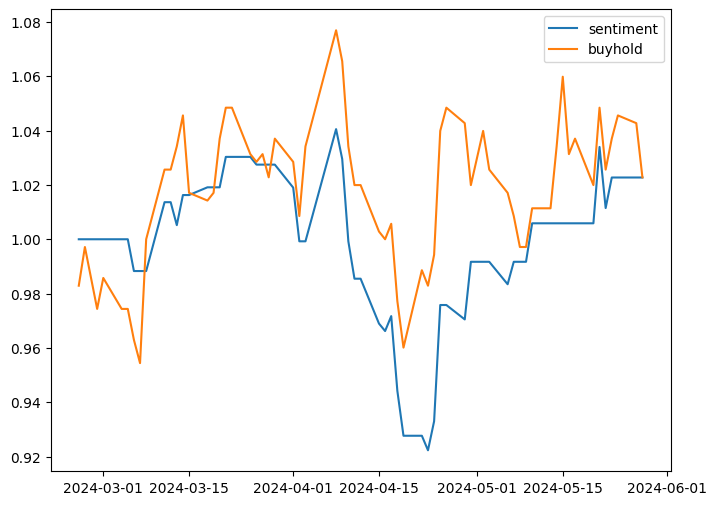

{'eval_loss': 5.984399318695068, 'eval_accuracy': 0.28, 'eval_runtime': 0.2429, 'eval_samples_per_second': 102.919, 'eval_steps_per_second': 4.117, 'epoch': 3.33}
{'eval_loss': 5.754653453826904, 'eval_accuracy': 0.28, 'eval_runtime': 0.2477, 'eval_samples_per_second': 100.913, 'eval_steps_per_second': 4.037, 'epoch': 6.67}
{'eval_loss': 5.379091262817383, 'eval_accuracy': 0.32, 'eval_runtime': 0.2475, 'eval_samples_per_second': 101.021, 'eval_steps_per_second': 4.041, 'epoch': 10.0}
{'eval_loss': 4.870835304260254, 'eval_accuracy': 0.32, 'eval_runtime': 0.2485, 'eval_samples_per_second': 100.622, 'eval_steps_per_second': 4.025, 'epoch': 13.33}
{'eval_loss': 4.258767127990723, 'eval_accuracy': 0.32, 'eval_runtime': 0.2494, 'eval_samples_per_second': 100.227, 'eval_steps_per_second': 4.009, 'epoch': 16.67}
{'eval_loss': 3.6471545696258545, 'eval_accuracy': 0.4, 'eval_runtime': 0.2484, 'eval_samples_per_second': 100.653, 'eval_steps_per_second': 4.026, 'epoch': 20.0}
{'eval_loss': 3.1336

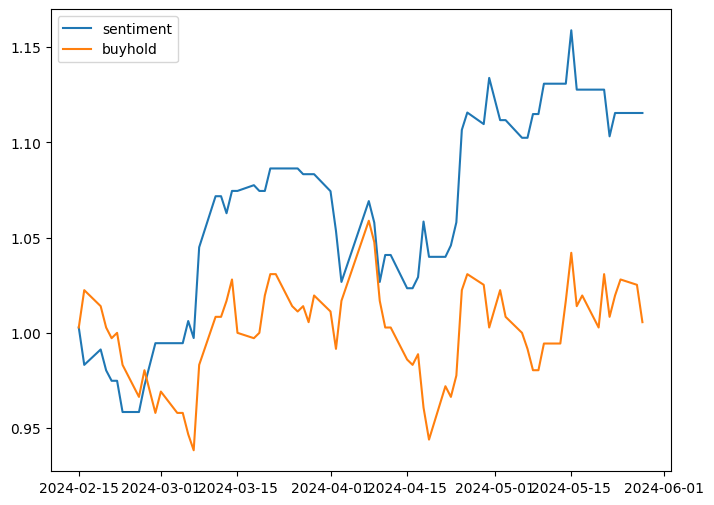

In [7]:
"""
NOTE:
- The first file is the target stock
- Train with target stock data and other stock data
"""
filename_news = [
    f'data/TW-stock-news-price/date/NEWS_{MEDIA}_{KEYWORD}_EN.json',
    'data/TW-stock-news-price/date/NEWS_UDN_ETF_EN.json'
    ]
filename_price = [
    f'data/TW-stock-news-price/date/PRICE_{STOCK}_{DAY_RANGE}.pickle',
    'data/TW-stock-news-price/date/PRICE_0050.TW_1d.pickle'
    ]
filename_log = f'logs/finBert_day_ERROR_{MEDIA}_{KEYWORD}'
senti = finBert_Sentiment(MEDIA, KEYWORD, STOCK, DAY_RANGE, content_type, filename_news, filename_price, filename_log)
senti.set_seeds()

all, train, val, test = senti.load_data(text_type = 'title')
result = senti.finetuneFull_score_trade(True)
# result = senti.finetuneLora_score_trade(True)

## 2454

In [8]:
MEDIA = 'UDN'
KEYWORD = '聯發科'
STOCK = '2454.TW'
DAY_RANGE = '1d'
content_type = 'Title'

100%|██████████| 3423/3423 [00:02<00:00, 1252.18it/s]


Map:   0%|          | 0/269 [00:00<?, ? examples/s]

Map:   0%|          | 0/174 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Average daily return | sentiment: 0.002101652777959332 | buyhold: 0.004396681491324988
Std daily return     | sentiment: 0.018575710244995134  | buyhold: 0.026355250132975166


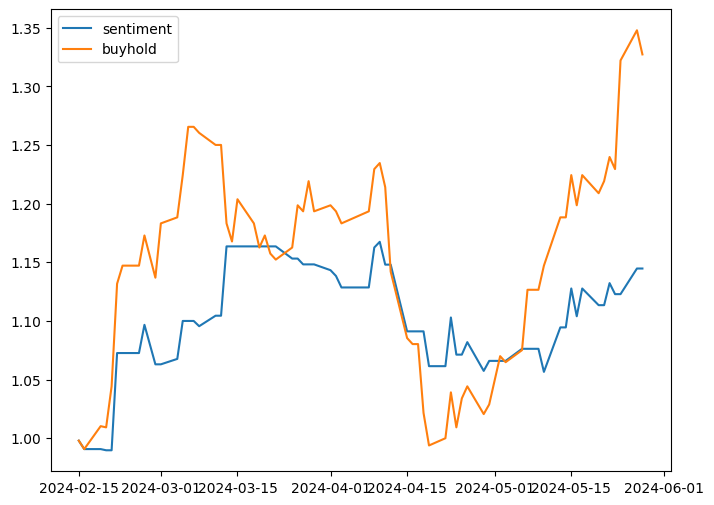

{'eval_loss': 6.6902947425842285, 'eval_accuracy': 0.24, 'eval_runtime': 0.2438, 'eval_samples_per_second': 102.545, 'eval_steps_per_second': 4.102, 'epoch': 6.67}
{'eval_loss': 6.389334201812744, 'eval_accuracy': 0.28, 'eval_runtime': 0.2466, 'eval_samples_per_second': 101.364, 'eval_steps_per_second': 4.055, 'epoch': 13.33}
{'eval_loss': 5.9034905433654785, 'eval_accuracy': 0.28, 'eval_runtime': 0.2478, 'eval_samples_per_second': 100.876, 'eval_steps_per_second': 4.035, 'epoch': 20.0}
{'eval_loss': 5.204456329345703, 'eval_accuracy': 0.32, 'eval_runtime': 0.2466, 'eval_samples_per_second': 101.365, 'eval_steps_per_second': 4.055, 'epoch': 26.67}
{'eval_loss': 4.329140663146973, 'eval_accuracy': 0.28, 'eval_runtime': 0.2476, 'eval_samples_per_second': 100.963, 'eval_steps_per_second': 4.039, 'epoch': 33.33}
{'eval_loss': 3.568605422973633, 'eval_accuracy': 0.28, 'eval_runtime': 0.2493, 'eval_samples_per_second': 100.295, 'eval_steps_per_second': 4.012, 'epoch': 40.0}
{'eval_loss': 3.1

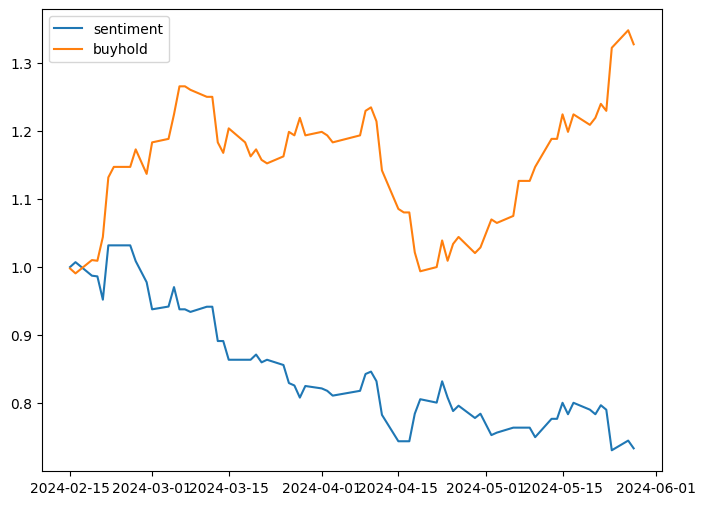

In [9]:
"""
NOTE:
- The first file is the target stock
- Train with target stock data and other stock data
"""
filename_news = [
    f'data/TW-stock-news-price/date/NEWS_{MEDIA}_{KEYWORD}_EN.json',
    # 'data/TW-stock-news-price/date/NEWS_UDN_ETF_EN.json'
    ]
filename_price = [
    f'data/TW-stock-news-price/date/PRICE_{STOCK}_{DAY_RANGE}.pickle',
    # 'data/TW-stock-news-price/date/PRICE_0050.TW_1d.pickle'
    ]
filename_log = f'logs/finBert_day_ERROR_{MEDIA}_{KEYWORD}'
senti = finBert_Sentiment(MEDIA, KEYWORD, STOCK, DAY_RANGE, content_type, filename_news, filename_price, filename_log)
senti.set_seeds()

all, train, val, test = senti.load_data(text_type = 'title')
senti.evaluate_with_pretrained()
result = senti.finetuneFull_score_trade(True)
# result = senti.finetuneLora_score_trade(True)

100%|██████████| 6623/6623 [00:05<00:00, 1275.71it/s]


Map:   0%|          | 0/269 [00:00<?, ? examples/s]

Map:   0%|          | 0/382 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

{'eval_loss': 6.678859710693359, 'eval_accuracy': 0.24, 'eval_runtime': 0.2444, 'eval_samples_per_second': 102.289, 'eval_steps_per_second': 4.092, 'epoch': 3.33}
{'eval_loss': 6.320145130157471, 'eval_accuracy': 0.28, 'eval_runtime': 0.2476, 'eval_samples_per_second': 100.956, 'eval_steps_per_second': 4.038, 'epoch': 6.67}
{'eval_loss': 5.758182525634766, 'eval_accuracy': 0.28, 'eval_runtime': 0.2478, 'eval_samples_per_second': 100.869, 'eval_steps_per_second': 4.035, 'epoch': 10.0}
{'eval_loss': 5.0307793617248535, 'eval_accuracy': 0.28, 'eval_runtime': 0.2492, 'eval_samples_per_second': 100.324, 'eval_steps_per_second': 4.013, 'epoch': 13.33}
{'eval_loss': 4.164113998413086, 'eval_accuracy': 0.24, 'eval_runtime': 0.2505, 'eval_samples_per_second': 99.781, 'eval_steps_per_second': 3.991, 'epoch': 16.67}
{'eval_loss': 3.373661756515503, 'eval_accuracy': 0.24, 'eval_runtime': 0.2482, 'eval_samples_per_second': 100.727, 'eval_steps_per_second': 4.029, 'epoch': 20.0}
{'eval_loss': 2.8072

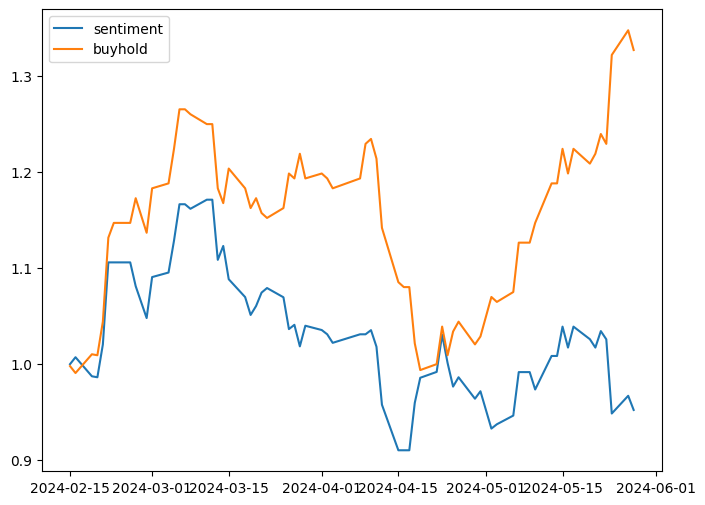

In [10]:
MEDIA = 'UDN'
KEYWORD = '聯發科'
STOCK = '2454.TW'
DAY_RANGE = '1d'
content_type = 'Title'
"""
NOTE:
- The first file is the target stock
- Train with target stock data and other stock data
"""
filename_news = [
    f'data/TW-stock-news-price/date/NEWS_{MEDIA}_{KEYWORD}_EN.json',
    'data/TW-stock-news-price/date/NEWS_UDN_ETF_EN.json'
    ]
filename_price = [
    f'data/TW-stock-news-price/date/PRICE_{STOCK}_{DAY_RANGE}.pickle',
    'data/TW-stock-news-price/date/PRICE_0050.TW_1d.pickle'
    ]
filename_log = f'logs/finBert_day_ERROR_{MEDIA}_{KEYWORD}'
senti = finBert_Sentiment(MEDIA, KEYWORD, STOCK, DAY_RANGE, content_type, filename_news, filename_price, filename_log)
senti.set_seeds()

all, train, val, test = senti.load_data(text_type = 'title')
# senti.evaluate_with_pretrained()
result = senti.finetuneFull_score_trade(True)
# result = senti.finetuneLora_score_trade(True)

## 2330

In [11]:
MEDIA = 'UDN'
KEYWORD = '台積電'
STOCK = '2330.TW'
DAY_RANGE = '1d'
content_type = 'Title'

100%|██████████| 10195/10195 [00:07<00:00, 1368.45it/s]


Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Average daily return | sentiment: 0.0013387478359928402 | buyhold: 0.003523477705993249
Std daily return     | sentiment: 0.015292010172713059  | buyhold: 0.01929515899054234


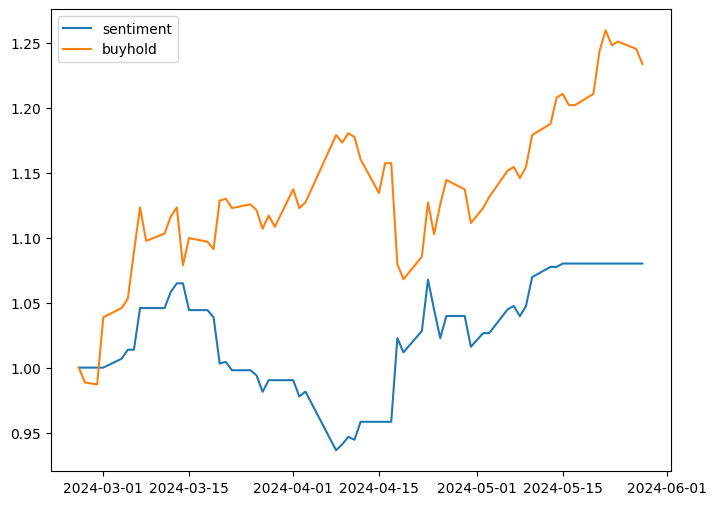

{'eval_loss': 4.024088382720947, 'eval_accuracy': 0.44, 'eval_runtime': 0.2432, 'eval_samples_per_second': 102.789, 'eval_steps_per_second': 4.112, 'epoch': 5.0}
{'eval_loss': 3.9294207096099854, 'eval_accuracy': 0.48, 'eval_runtime': 0.2445, 'eval_samples_per_second': 102.261, 'eval_steps_per_second': 4.09, 'epoch': 10.0}
{'eval_loss': 3.7610573768615723, 'eval_accuracy': 0.48, 'eval_runtime': 0.2466, 'eval_samples_per_second': 101.373, 'eval_steps_per_second': 4.055, 'epoch': 15.0}
{'eval_loss': 3.5575497150421143, 'eval_accuracy': 0.44, 'eval_runtime': 0.2489, 'eval_samples_per_second': 100.459, 'eval_steps_per_second': 4.018, 'epoch': 20.0}
{'eval_loss': 3.2986600399017334, 'eval_accuracy': 0.44, 'eval_runtime': 0.2463, 'eval_samples_per_second': 101.516, 'eval_steps_per_second': 4.061, 'epoch': 25.0}
{'eval_loss': 2.9576961994171143, 'eval_accuracy': 0.4, 'eval_runtime': 0.2479, 'eval_samples_per_second': 100.83, 'eval_steps_per_second': 4.033, 'epoch': 30.0}
{'eval_loss': 2.61066

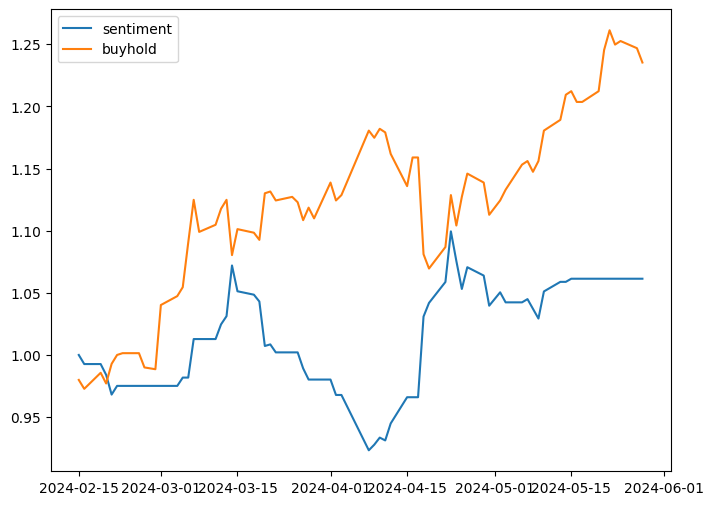

In [12]:
"""
NOTE:
- The first file is the target stock
- Train with target stock data and other stock data
"""
filename_news = [
    f'data/TW-stock-news-price/date/NEWS_{MEDIA}_{KEYWORD}_EN.json',
    # 'data/TW-stock-news-price/date/NEWS_UDN_ETF_EN.json'
    ]
filename_price = [
    f'data/TW-stock-news-price/date/PRICE_{STOCK}_{DAY_RANGE}.pickle',
    # 'data/TW-stock-news-price/date/PRICE_0050.TW_1d.pickle'
    ]
filename_log = f'logs/finBert_day_ERROR_{MEDIA}_{KEYWORD}'
senti = finBert_Sentiment(MEDIA, KEYWORD, STOCK, DAY_RANGE, content_type, filename_news, filename_price, filename_log)
senti.set_seeds()

all, train, val, test = senti.load_data(text_type = 'title')
senti.evaluate_with_pretrained()
result = senti.finetuneFull_score_trade(True)
# result = senti.finetuneLora_score_trade(True)

100%|██████████| 6623/6623 [00:05<00:00, 1287.22it/s]


Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Map:   0%|          | 0/451 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

{'eval_loss': 4.00929069519043, 'eval_accuracy': 0.44, 'eval_runtime': 0.2416, 'eval_samples_per_second': 103.465, 'eval_steps_per_second': 4.139, 'epoch': 2.67}
{'eval_loss': 3.8769283294677734, 'eval_accuracy': 0.44, 'eval_runtime': 0.2465, 'eval_samples_per_second': 101.401, 'eval_steps_per_second': 4.056, 'epoch': 5.33}
{'eval_loss': 3.6678552627563477, 'eval_accuracy': 0.48, 'eval_runtime': 0.2469, 'eval_samples_per_second': 101.262, 'eval_steps_per_second': 4.05, 'epoch': 8.0}
{'eval_loss': 3.4394335746765137, 'eval_accuracy': 0.48, 'eval_runtime': 0.249, 'eval_samples_per_second': 100.399, 'eval_steps_per_second': 4.016, 'epoch': 10.67}
{'eval_loss': 3.180579423904419, 'eval_accuracy': 0.4, 'eval_runtime': 0.2498, 'eval_samples_per_second': 100.09, 'eval_steps_per_second': 4.004, 'epoch': 13.33}
{'eval_loss': 2.947161912918091, 'eval_accuracy': 0.36, 'eval_runtime': 0.2482, 'eval_samples_per_second': 100.722, 'eval_steps_per_second': 4.029, 'epoch': 16.0}
{'eval_loss': 2.6919579

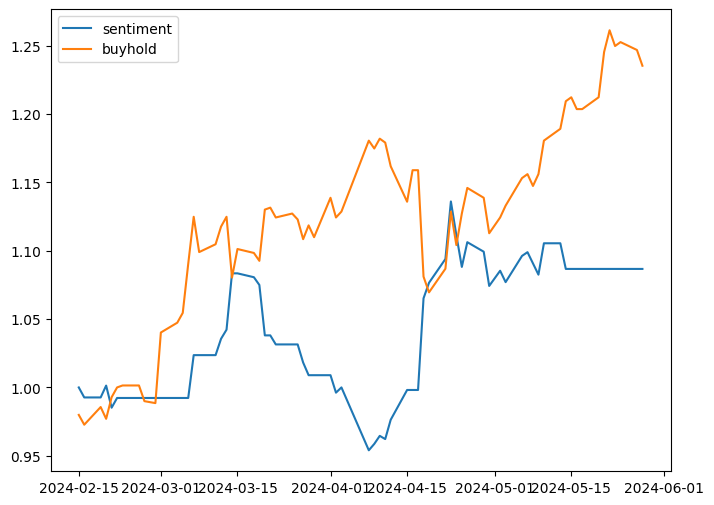

In [13]:
"""
NOTE:
- The first file is the target stock
- Train with target stock data and other stock data
"""
filename_news = [
    f'data/TW-stock-news-price/date/NEWS_{MEDIA}_{KEYWORD}_EN.json',
    'data/TW-stock-news-price/date/NEWS_UDN_ETF_EN.json'
    ]
filename_price = [
    f'data/TW-stock-news-price/date/PRICE_{STOCK}_{DAY_RANGE}.pickle',
    'data/TW-stock-news-price/date/PRICE_0050.TW_1d.pickle'
    ]
filename_log = f'logs/finBert_day_ERROR_{MEDIA}_{KEYWORD}'
senti = finBert_Sentiment(MEDIA, KEYWORD, STOCK, DAY_RANGE, content_type, filename_news, filename_price, filename_log)
senti.set_seeds()

all, train, val, test = senti.load_data(text_type = 'title')
result = senti.finetuneFull_score_trade(True)
# result = senti.finetuneLora_score_trade(True)

## 5871

In [14]:
MEDIA = 'UDN'
KEYWORD = '中租'
STOCK = '5871.TW'
DAY_RANGE = '1d'
content_type = 'Title'

100%|██████████| 323/323 [00:00<00:00, 898.85it/s] 


Map:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/92 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Average daily return | sentiment: 0.001256996693839747 | buyhold: -0.002441682820117839
Std daily return     | sentiment: 0.005510508643457153  | buyhold: 0.020186966770647848


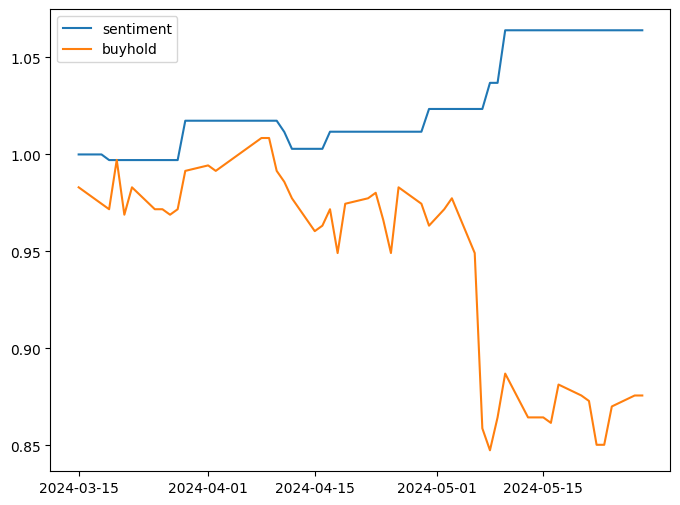

{'eval_loss': 9.556325912475586, 'eval_accuracy': 0.13333333333333333, 'eval_runtime': 0.1569, 'eval_samples_per_second': 95.611, 'eval_steps_per_second': 6.374, 'epoch': 6.67}
{'eval_loss': 9.384306907653809, 'eval_accuracy': 0.13333333333333333, 'eval_runtime': 0.1593, 'eval_samples_per_second': 94.182, 'eval_steps_per_second': 6.279, 'epoch': 13.33}
{'eval_loss': 9.144806861877441, 'eval_accuracy': 0.13333333333333333, 'eval_runtime': 0.1582, 'eval_samples_per_second': 94.807, 'eval_steps_per_second': 6.32, 'epoch': 20.0}
{'eval_loss': 8.874483108520508, 'eval_accuracy': 0.13333333333333333, 'eval_runtime': 0.1602, 'eval_samples_per_second': 93.637, 'eval_steps_per_second': 6.242, 'epoch': 26.67}
{'eval_loss': 8.474844932556152, 'eval_accuracy': 0.2, 'eval_runtime': 0.1603, 'eval_samples_per_second': 93.588, 'eval_steps_per_second': 6.239, 'epoch': 33.33}
{'eval_loss': 8.058655738830566, 'eval_accuracy': 0.2, 'eval_runtime': 0.1603, 'eval_samples_per_second': 93.564, 'eval_steps_per

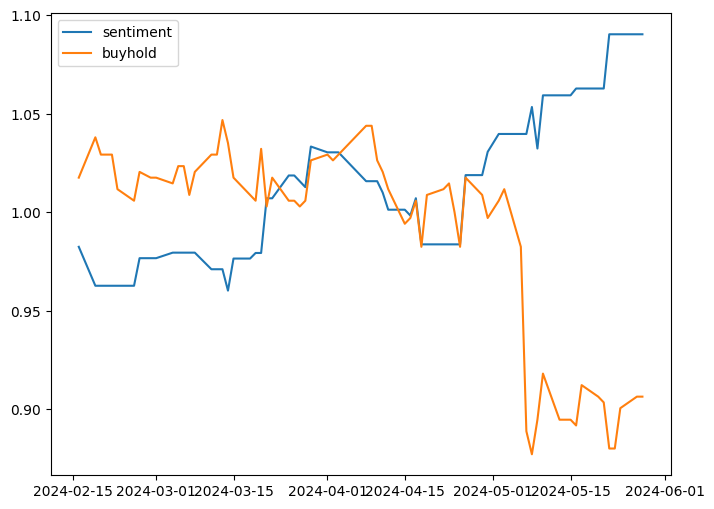

In [15]:
"""
NOTE:
- The first file is the target stock
- Train with target stock data and other stock data
"""
filename_news = [
    f'data/TW-stock-news-price/date/NEWS_{MEDIA}_{KEYWORD}_EN.json',
    # 'data/TW-stock-news-price/date/NEWS_UDN_ETF_EN.json'
    ]
filename_price = [
    f'data/TW-stock-news-price/date/PRICE_{STOCK}_{DAY_RANGE}.pickle',
    # 'data/TW-stock-news-price/date/PRICE_0050.TW_1d.pickle'
    ]
filename_log = f'logs/finBert_day_ERROR_{MEDIA}_{KEYWORD}'
senti = finBert_Sentiment(MEDIA, KEYWORD, STOCK, DAY_RANGE, content_type, filename_news, filename_price, filename_log)
senti.set_seeds()

all, train, val, test = senti.load_data(text_type = 'title')
senti.evaluate_with_pretrained()
result = senti.finetuneFull_score_trade(True)
# result = senti.finetuneLora_score_trade(True)

100%|██████████| 6623/6623 [00:04<00:00, 1343.22it/s]


Map:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 9.521540641784668, 'eval_accuracy': 0.13333333333333333, 'eval_runtime': 0.1589, 'eval_samples_per_second': 94.424, 'eval_steps_per_second': 6.295, 'epoch': 4.0}


{'eval_loss': 9.237062454223633, 'eval_accuracy': 0.13333333333333333, 'eval_runtime': 0.1583, 'eval_samples_per_second': 94.775, 'eval_steps_per_second': 6.318, 'epoch': 8.0}
{'eval_loss': 8.752518653869629, 'eval_accuracy': 0.13333333333333333, 'eval_runtime': 0.1622, 'eval_samples_per_second': 92.458, 'eval_steps_per_second': 6.164, 'epoch': 12.0}
{'eval_loss': 8.077802658081055, 'eval_accuracy': 0.2, 'eval_runtime': 0.1606, 'eval_samples_per_second': 93.402, 'eval_steps_per_second': 6.227, 'epoch': 16.0}
{'eval_loss': 7.221573352813721, 'eval_accuracy': 0.13333333333333333, 'eval_runtime': 0.1618, 'eval_samples_per_second': 92.72, 'eval_steps_per_second': 6.181, 'epoch': 20.0}
{'eval_loss': 6.291077613830566, 'eval_accuracy': 0.13333333333333333, 'eval_runtime': 0.1594, 'eval_samples_per_second': 94.114, 'eval_steps_per_second': 6.274, 'epoch': 24.0}
{'eval_loss': 5.470908164978027, 'eval_accuracy': 0.13333333333333333, 'eval_runtime': 0.1607, 'eval_samples_per_second': 93.36, 'eva

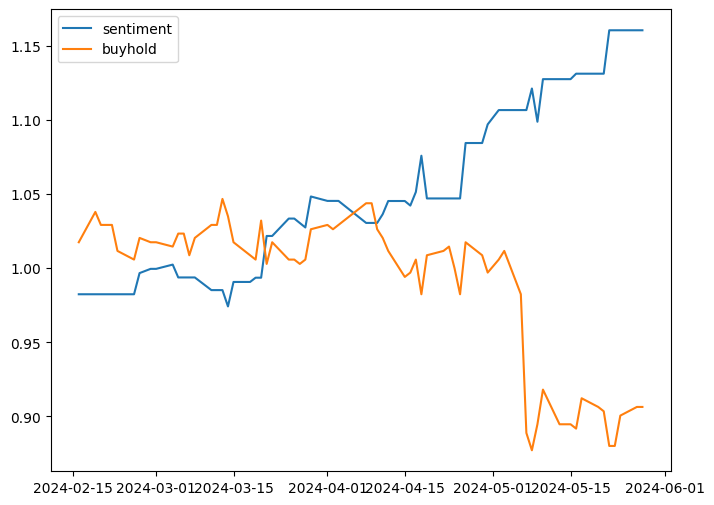

In [16]:
"""
NOTE:
- The first file is the target stock
- Train with target stock data and other stock data
"""
filename_news = [
    f'data/TW-stock-news-price/date/NEWS_{MEDIA}_{KEYWORD}_EN.json',
    'data/TW-stock-news-price/date/NEWS_UDN_ETF_EN.json'
    ]
filename_price = [
    f'data/TW-stock-news-price/date/PRICE_{STOCK}_{DAY_RANGE}.pickle',
    'data/TW-stock-news-price/date/PRICE_0050.TW_1d.pickle'
    ]
filename_log = f'logs/finBert_day_ERROR_{MEDIA}_{KEYWORD}'
senti = finBert_Sentiment(MEDIA, KEYWORD, STOCK, DAY_RANGE, content_type, filename_news, filename_price, filename_log)
senti.set_seeds()

all, train, val, test = senti.load_data(text_type = 'title')
result = senti.finetuneFull_score_trade(True)
# result = senti.finetuneLora_score_trade(True)

## 1